# Adam Thomson - PHY574 - Week 1

## Quantum Error Correction via Repetition Code

Follow the qiskit error correction via repetition notebook until the lookup table section https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/error-correction-repetition-code.ipynb
- Copy the code blocks, comment on each line
- Run as-is
- Modify the input and compare against expectation

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import gcd
from numpy.random import randint
from IPython.display import Math, HTML
from qiskit import QuantumCircuit as QCir, \
                   QuantumRegister as QReg, \
                   ClassicalRegister as CReg, \
                   transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import pauli_error, depolarizing_error

# Initialize local simulator
sampler = AerSimulator()

# Declare shortcut function
def dm(x):
    return display(Math(x))

#### Introduction

The purpose of this notebook will be to demonstrate how _logical qubits_ can be translated into multiple _physical qubits_ for the sake of implementing repetition-based error correction. While this is not a true example of quantum error correction, it serves as a guide to the basic concepts.

### Introduction to the repetition code

In a general sense, meaningful communication relies on two key factors: a stable connection, and the ability to be understood correctly. We can represent these concepts mathematically with the following symbols.

In [2]:
dm(r"P_a = \text{ the maximum acceptable probability of being misunderstood.}")
dm(r"p = \text{ the probability that a bad connection corrupts your message.}")
dm(r"\text{With a stable connection and an unimportant question } p < P_a.")
dm(r"\text{But with a poor connection and/or important question, } p > P_a \text{ is unacceptable.}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

To mitigate the risk of being misunderstood, we encode the message into a more complex structure that allows for minor disruptions. The simplest method is to repeat the message multiple times (eg. 3) and instruct the recipient to use the majority message received. Let's examine the statistics involved with this approach using different values of p and P_a.

In [3]:
# Copy qiskit code
def compare_corruption_prob(p):
    # Set our p; probability of a single corruption = 1% chance
    p1 = p
    # Use combinatorics to calculate probability of corrupting decoded triplicate 
    # = P(2 corruptions) x3 [because there are 3 ways to have 2 corruptions]
    #   + P(3 corruptions)
    p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors

    # Display probabilities for comparison
    print(f'Probability of a single reply being garbled: {p1}')
    # Round for display purposes
    print(f'Probability of a the majority of three replies being garbled: {p3:.6f}')

In [4]:
# Run the notebook example
compare_corruption_prob(0.01)

Probability of a single reply being garbled: 0.01
Probability of a the majority of three replies being garbled: 0.000298


We see that the probability of an encoded message being corrupted is much less than an unencoded message! Let's change p1 to compare results.

In [5]:
# Compare to with lower p = 0.1%
compare_corruption_prob(0.001)

Probability of a single reply being garbled: 0.001
Probability of a the majority of three replies being garbled: 0.000003


As expected, with a lower p we see that p_3 decreases as well.

In [6]:
# Compare with larger p = 10%
compare_corruption_prob(0.1)

Probability of a single reply being garbled: 0.1
Probability of a the majority of three replies being garbled: 0.028000


In [7]:
# Compare with larger p = 33%
compare_corruption_prob(0.33)

Probability of a single reply being garbled: 0.33
Probability of a the majority of three replies being garbled: 0.254826


In [8]:
# Compare with p = 50%
compare_corruption_prob(0.5)

Probability of a single reply being garbled: 0.5
Probability of a the majority of three replies being garbled: 0.500000


In [9]:
# Compare with p > 50%
compare_corruption_prob(0.6)

Probability of a single reply being garbled: 0.6
Probability of a the majority of three replies being garbled: 0.648000


As p increases, we see an interesting trend. As p approaches 50%, the effectiveness of encoding the message decreases until it is exactly the same probability of corruption with an encoded message at p = 50%. As p continues to grow, the process of encoding the message will cause more error than the original unencoded message! However, if p > 50%, you could instruct the recipient to always flip the response and then treat the probability above as the chance of being understood correctly.

This means that if p_3 < P_a then we have successfully mitigated the problem and can proceed to sending messages. If our p_3 is still too high, we can simply add more repetitions until p_n < P_a.

Let's now examine how this method can be applied to qubits.

### Correcting errors in qubits

To demonstrate error correction on imperfect qubits, we can either run on real quantum hardware or reproduce the effects in simulation via a noise model. This noise model will simulate two kinds of bit corruption:

In [10]:
dm(r"p_{gate} = \text{ the probability that a logic gate will put a qubit into a random state}")
dm(r"p_{meas} = \text{ the probability of corruption during the measurement process}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
# Define function to generate noise models
def get_noise(p_meas, p_gate):
    """
    Generate and return a noise model based on input probabilities
    
    Parameters:
    p_meas (float): probability of corruption during the measurement process
    p_gate (float): probability that a logic gate will put a qubit into a random state

    Returns:
    qiskit_aer.noise.NoiseModel
    """
    # Use input p_meas to randomly determine if an X gate or I gate should be applied
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])

    # Use the qiskit included library to generate the 1-qubit and 2-qubit error gates
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()                                     # Initiliaze a qiskit NoiseModel
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"])    # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])   # two qubit gate error is applied to cx gates
        
    return noise_model

In [12]:
# Test the noise model
dm(r"\text{Let's examine the case when } p_{meas} = p_{gate} = 0.01 = 1\%")
nm_01 = get_noise(0.01, 0.01)

<IPython.core.display.Math object>

We'll test this by trying the trivial case of storing `0` with 3 qubits as |0> and immediately measuring

In [13]:
# Run the trivial test circuit

# Initialize quantum circuit with 3 qubits as |0>
qc01 = QCir(3, name="01")

# Measure the qubits
qc01.measure_all()

# Run on local simulator with the 1% noise model
counts01 = sampler.run([qc01], noise_model=nm_01).result().get_counts()

print(counts01)

{'110': 2, '001': 9, '100': 12, '010': 8, '000': 993}


In [14]:
# Verify that almost all (> 95%) results are still '000'
assert counts01['000'] > sum(counts01.values())*0.95

Note that you have to run the test circuit many times to get a single instance of decoded corruption. Most of the time, out of the 1024 shots there are no results that would decode to `1` instead of `0`. But what about with a different p?

In [15]:
# Generate a noise model with p_meas = 10%
nm_10 = get_noise(0.1, 0)
qc10 = QCir(3, name="10")
qc10.measure_all()
counts10 = sampler.run([qc10], noise_model=nm_10).result().get_counts()
print(counts10)

{'110': 10, '111': 2, '011': 7, '101': 12, '001': 76, '010': 95, '000': 755, '100': 67}


By increasing p to 0.1, we now consistently see results that would decode incorrectly to |1> instead of |0>

In [16]:
# Generate a noise model with p_meas=0.5
nm_50 = get_noise(0.5, 0)
qc50 = QCir(3, name="50")
qc50.measure_all()
counts50 = sampler.run([qc50], noise_model=nm_50).result().get_counts()
print(counts50)

{'110': 131, '101': 135, '010': 128, '000': 133, '100': 116, '001': 111, '111': 129, '011': 141}


With p_meas = 50%, we see that the results are equally likely to result in decoding to either a |0> or |1>

### Storing qubits

This noise model assumes that there is no significant time passing between initialization and measurement. To address this, we need to incorporate error into our noise model for idle qubits. In reality, if qubits are ignored for long enough then we approach p_idle = 0.5 and the noise is too strong for error correction.

If we need to store a |0> or |1> for a long time, then we can do that easily by taking constant measurements and correcting if needed. But if we wanted to store |+>, how would we do that with measurements along the Z-axis? Furthermore, how do we maintain a superposition state over a period of time if we're taking a measurement?

Clearly, we need to find a different way of keeping track of and correcting errors that build up in qubits stored over time that maintains the _logical_ superposition.

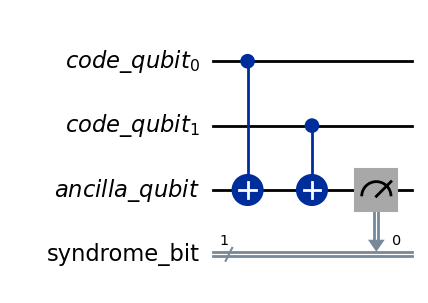

In [17]:
# Copy the qiskit syndrome bit circuit
cq = QReg(2, 'code_qubit')      # Define the 2 input qubits
lq = QReg(1, 'ancilla_qubit')   # Define the ancillary qubit
sb = CReg(1, 'syndrome_bit')    # Define the output classical bit
qc = QCir(cq, lq, sb)           # Construct the full circuit with 3 registers
qc.cx(cq[0], lq[0])             # Apply a CX gate on the ancilla_qubit with first input control
qc.cx(cq[1], lq[0])             # Apply a CX gate on the ancilla_qubit with second input control
qc.measure(lq, sb)              # Measure the ancilla qubit to the classical register
qc.draw(output="mpl")

Let's examine the output of this circuit for various inputs

In [18]:
# Examine the trivial case
qc_init = QCir(cq, lq, sb)  # Initialize a new quantum circuit with same registers
qc_init = qc_init.compose(qc) # Perform the same steps as above
# Run on a simulator (with no noise model)
qc_init_counts = sampler.run([qc_init]).result().get_counts()
print(f"Results: {qc_init_counts}")

Results: {'0': 1024}


In [19]:
# Verify that all results are 0
assert list(qc_init_counts.keys()) == ['0']

As expected, when input is |00>, output is always 0. What about using |11> as input? Because the ancilla qubit is having the CX gate applied twice, we would still expect to have 0 as output.

Results: {'0': 1024}


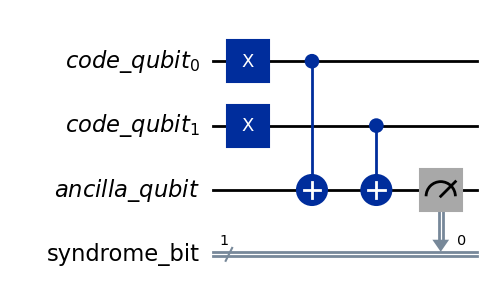

In [20]:
# Examine using |11> as input
qc_11 = QCir(cq, lq, sb)    # Initialize a new quantum circuit with same registers
qc_11.x(cq)                 # Apply X gate to input qubits  
qc_11 = qc_11.compose(qc)   # Perform the same steps as above
# Run on a simulator (with no noise model)
qc_11_counts = sampler.run([qc_11]).result().get_counts()
print(f"Results: {qc_11_counts}")
qc_11.draw(output="mpl")

In [21]:
# Verify that all results are 0
assert list(qc_11_counts.keys()) == ['0']

From these assertions, it follows that any superposition of |00> and |11> should always result in 0 as well.

Results: {'0': 1024}


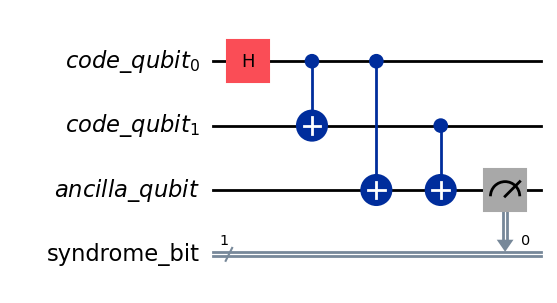

In [22]:
# Examine using a|00> + b|11> as input
qc_bell = QCir(cq, lq, sb)   # Initialize a new quantum circuit with same registers

# Use a combination of H and CX gate to put input qubits into a Bell state
qc_bell.h(cq[0])
qc_bell.cx(cq[0], cq[1])

qc_bell = qc_bell.compose(qc) # Perform the same steps as above

qc_bell_counts = sampler.run([qc_bell]).result().get_counts()
print(f"Results: {qc_bell_counts}")
qc_bell.draw(output="mpl")

In [23]:
# Verify that all results are 0
assert list(qc_bell_counts.keys()) == ['0']

Indeed, we find that any superposition of |00> and |11> will always result in the syndrome bit measuring `0`.

Let's confirm that the opposite holds true, that any superposition of |01> and |10> will always result in the syndrome bit measuring `1`.

Results: {'1': 1024}


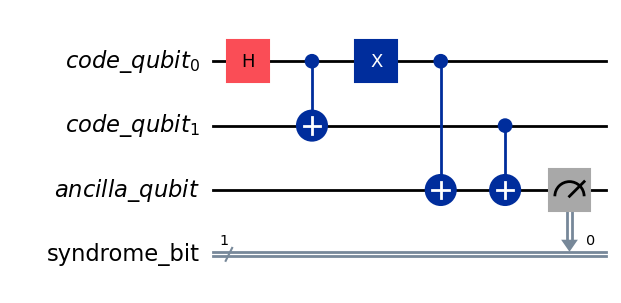

In [24]:
# Examine using a|01> + b|10> as input
qc_bell2 = QCir(cq, lq, sb)   # Initialize a new quantum circuit with same registers

# Use a combination of H and CX gate to put input qubits into a Bell state
qc_bell2.h(cq[0])
qc_bell2.cx(cq[0], cq[1])
qc_bell2.x(cq[0])

qc_bell2 = qc_bell2.compose(qc) # Perform the same steps as above

qc_bell2_counts = sampler.run([qc_bell2]).result().get_counts()
print(f"Results: {qc_bell2_counts}")
qc_bell2.draw(output="mpl")

In [25]:
# Verify that all results are 0
assert list(qc_bell2_counts.keys()) == ['1']

This shows us that we have the ability to take measurement of an ancillary qubit to determine if 2 input qubits would z-measure to equal or opposite values. If we apply this method to all pairs of physical qubits in the repetition code, then we can determine how to decode the result.

### Quantum repetition code

In [26]:
# Import NCCR_SPIN/topological codes

# Note: I needed to modify the topological_codes/fitter.py file to update the Aer import path to be compatible with latest qiskit

from topological_codes import RepetitionCode
from topological_codes import lookuptable_decoding
from topological_codes import GraphDecoder

With this method, we are free to choose how many qubits are used for encoding and how many syndrome measurements are applied before readout. Let's start by recreating the classical example of encoding into 3 qubits with a single syndrome measurement.

In [33]:
# Define the quantum repetition code
n = 3   # encode to 3 qubits
t = 1   # single syndrome measurement

code = RepetitionCode(n, t)  # Generate quantum circuits

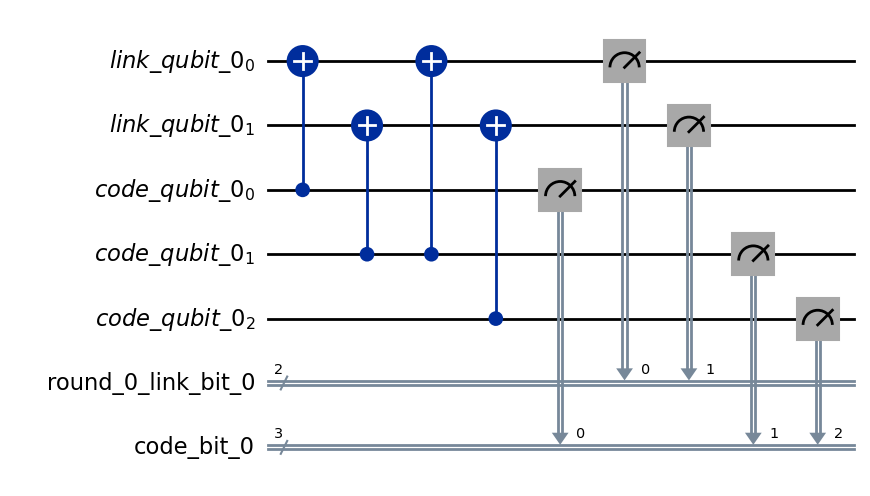

In [28]:
# examine the quantum circuit for output=0
code.circuit['0'].draw(output="mpl")

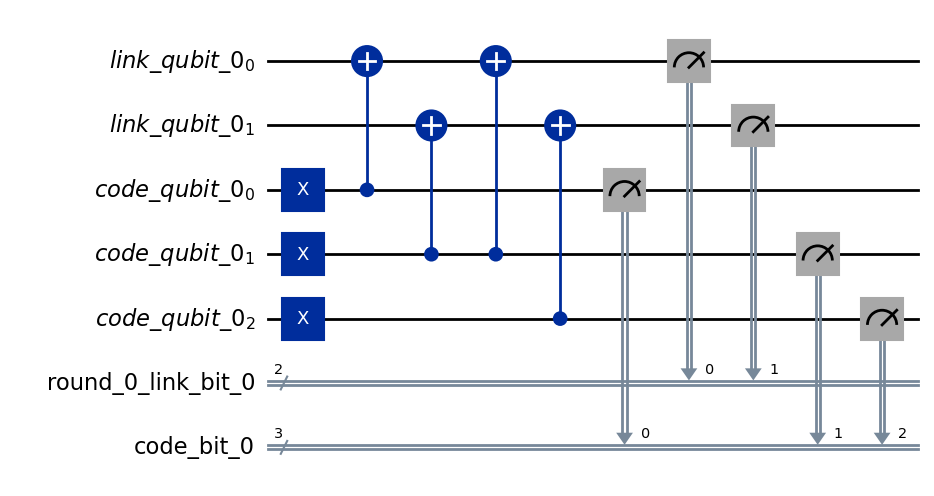

In [29]:
# examine the quantum circuit for output=1
code.circuit['1'].draw(output="mpl")

In these circuits we have two different quantum registers: _code qubits_ in which the state is encoded, and _link qubits_ which are ancillary to syndrome measurements. We see that a single round of syndrome measurements translates to two measurements that translate to comparing _code qubits_ 0-to-1 and 1-to-2. Note that it is redundant to also compare 0-to-2, and it follows that for `n` qubits we only need `n-1` syndrome measurements for each round.

Let's further examine the results of these circuits.

In [30]:
# Define helper function for examining results
def get_raw_results(code, noise_model=None):
    """
    Applies a NoiseModel to generated repetition circuits 

    Parameters:
        code (RepetitionCode)    : generated by topological_codes library based on encoding qubits and syndrome rounds
        noise_model (NoiseModel) : will be used as noise model for simulation purposes

    Returns:
        dict: A dictionary containing simulation result counts
    """
    circuits = code.get_circuit_list()   # Fetch the circuits generated by RepetitionCode
    raw_results = {}                     # Initialize the return object
    for log in range(2):                 # Perform loop on both circuits in the RepetitionCode
        # Run the circuit with noisy simulation
        job = sampler.run(circuits[log], noise_model=noise_model)
        # Add results to return object
        raw_results[str(log)] = job.result().get_counts(str(log))

    return raw_results

In [31]:
# Examine our case for n=3, T=1
# Use the repetition code from above
raw_results = get_raw_results(code)
# Print the results
for log in raw_results:
    print(f'Logical {log}: {raw_results[log]}')

Logical 0: {'000 00': 1024}
Logical 1: {'111 00': 1024}


This matches our expectations for when there is no noise in the simulation: for each logical qubit value we found that the final readout matched the expectation for all 1024 shots and that the syndrome measurements were `00` in the single round.

Let's increase T and examine how the results change.

In [36]:
# examine increased T
t = 3                         # Set T=3
code3 = RepetitionCode(n, t)  # Generate new RepetitionCode for (n=3, T=3)
raw_results3 = get_raw_results(code3) # Simulate new circuits
# Print the results
for log in raw_results3:
    print(f'Logical {log}: {raw_results3[log]}')

Logical 0: {'000 00 00 00': 1024}
Logical 1: {'111 00 00 00': 1024}


We see that by adding more syndrome measurement rounds more `00` pairs are included in the log, and all 1024 shots result in the expected logical measurement. This is because we haven't introduced a noise model to the circuit yet.

How does the output change if we increase the number of qubits used for encoding?

In [37]:
# examine increased n
n = 7                          # Set n=7
code7 = RepetitionCode(n, t)   # Generate new RepetitionCode for (n=7, T=3)
raw_results7 = get_raw_results(code7) # Simulate new circuits
# Print the results
for log in raw_results7:
    print(f'Logical {log}: {raw_results7[log]}')

Logical 0: {'0000000 000000 000000 000000': 1024}
Logical 1: {'1111111 000000 000000 000000': 1024}


In [42]:
# Examine the generated circuit

# Left commented for viewability, uncomment if curious
# code7.circuit['0'].draw(output="mpl")

These results continue to align with our expectations:
- All 1024 shots result in the final readout having the logical value we expect
- Each syndrome round requires `n-1=6` measurements
- Each syndrome round results in `000000` because the simulation is not using a noise model